# PCA Demo – Data 100, Fall 2019

by Suraj Rampure (suraj.rampure@berkeley.edu) and Mansi Shah (emansishah@berkeley.edu)

<br>

This notebook was designed to supplement Discussion 7 (Lab 8) in Fall 2019. It is not meant to be a substitute for lecture or other readings; rather, it's meant to provide an example of PCA in action, and explain steps along the way.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Getting the Data

In this demo, we will be performing PCA on player data from the 2018-19 NBA season. You can learn more about this dataset [here](https://www.basketball-reference.com/leagues/NBA_2019_per_game.html).

In [2]:
df = pd.read_csv('https://gist.githubusercontent.com/surajrampure/76bef6c3561b6d99fb87106cb91ef2b1/raw/c19e1300a1f8cc36ba93713261fcdcea00f4e8ed/nba_19_stats.csv')

We will keep only players who started over half the time, since it reduces noise for later visualizations.

In [3]:
df = df.query('GS >= 41')
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
7,8,LaMarcus Aldridge\aldrila01,C,33,SAS,81,81,33.2,8.4,16.3,...,0.847,3.1,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3
10,11,Jarrett Allen\allenja01,C,20,BRK,80,80,26.2,4.2,7.1,...,0.709,2.4,6.0,8.4,1.4,0.5,1.5,1.3,2.3,10.9
12,13,Al-Farouq Aminu\aminual01,PF,28,POR,81,81,28.3,3.2,7.3,...,0.867,1.4,6.1,7.5,1.3,0.8,0.4,0.9,1.8,9.4
19,18,Giannis Antetokounmpo\antetgi01,PF,24,MIL,72,72,32.8,10.0,17.3,...,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7


Furthermore, since PCA requires that our data comes in the form of a matrix, we will only look at numerical columns. We'll take everything starting from MP (minutes played), since this is where the "per game" statistics begin.

In [4]:
df.iloc[:, 7:].head()

,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
3,33.4,6.0,10.1,0.595,0.0,0.0,0.000,6.0,10.1,0.596,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
7,33.2,8.4,16.3,0.519,0.1,0.5,0.238,8.3,15.8,0.528,...,0.847,3.1,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3
10,26.2,4.2,7.1,0.590,0.1,0.6,0.133,4.1,6.5,0.629,...,0.709,2.4,6.0,8.4,1.4,0.5,1.5,1.3,2.3,10.9
12,28.3,3.2,7.3,0.433,1.2,3.5,0.343,2.0,3.9,0.514,...,0.867,1.4,6.1,7.5,1.3,0.8,0.4,0.9,1.8,9.4
19,32.8,10.0,17.3,0.578,0.7,2.8,0.256,9.3,14.5,0.641,...,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7


We currently have 23 numerical columns, i.e. each row of our data is 23-dimensional. With this many columns, it's hard to identify any patterns. Our goal will be to use PCA to reduce the dimensionality of our data.

## Normalize the Data
Let's first normalize our data by subtracting the mean from each column. 
- In general, we care more about the relative relationships between our variables, and not the absolute relationships. Normalizing our data prevents us from putting more weight on certain variables just because they are large. (Sometimes, for this reason, we also divide by the standard deviation of each column. We won't do this here.)
- There is also a more robust mathematical reason for needing to center our data – the projection that PCA generates is forced to go through the origin, and so we circumvent this by centering first. [This](https://stats.stackexchange.com/questions/22329/how-does-centering-the-data-get-rid-of-the-intercept-in-regression-and-pca) StackExchange thread has a great discussion about it (in addition to the slides from Lecture 11).

In [5]:
d = np.matrix(df.iloc[:, 7:].fillna(0)) # Replace NaNs with 0, then convert to a matrix
col_means = d.mean(axis = 0)

## Running Singular Value Decomposition

Recall, the singular value decomposition decomposes our data matrix $X$ into the product $U \Sigma V^T$, where 
- $U$ and $V$ are the left and right singular matrices, respectively
    - $U$ and $V$ have orthonormal columns, meaning each of their columns are of unit length and are orthogonal to each other
    - This also means that $U^TU = V^TV = I$

- $\Sigma$ is a diagonal matrix of singular values, which are sorted from greatest to least on the diagonal
    - The number of nonzero singular values in $\Sigma$ is the rank of $X$

We will extract meaning from each of these quantities shortly. For now, let's just perform the decomposition.

In [6]:
u, s, vt = np.linalg.svd(d - col_means, full_matrices = False)

## Determining the Number of Principal Components

Before we actually compute our principal components – i.e. the projection of our data onto our new directions – let's determine the number of principal components to use.

Choosing the number of principal components involves a tradeoff: if you choose too many principal components, you may defeat the purpose of doing dimensionality reduction in the first place. On the other hand, you don't want to choose too few principal components that you no longer capture much of the variance in the data. 

In this section, we will analyze the variance captured by each of the principal components. 

The singular values of our data matrix $X$ tell us how much variance each principal component captures. The variance of principal component $i$ is $\frac{\sigma_i^2}{N}$, i.e. $\frac{(\text{the $i$th singular value})^2}{\text{the number of data points}}$.

However, we don't care as much about the raw variance of a principal component – we care more about the proportion of the total variance in our dataset that a principal component captures. The **proportion of variance captured by the $i$th principal component** is $\frac{\sigma_i^2}{T}$, where $T = \sum_{i = 1}^r \sigma_i^2$ (i.e. the sum of the squares of all diagonal elements in $\Sigma$).

The proportion of variance captured by the first $k$ principal components together, then, is 

$$\frac{\sigma_1^2 + \sigma_2^2 + ... + \sigma_k^2}{T}$$

Typically, we will look to choose $k$ such that it captures a significant portion of our data's variance (usually > 80%).

In [7]:
# This function determines the proportion of variance captured by principal component i
def variance_captured(s, i):
  return s[i - 1]**2 / np.sum(s**2)

# This function determines the proportion of variance captured by principal components 1, 2, ..., k
def variance_captured_first_k(s, k):
  return sum([variance_captured(s, ki) for ki in range(1, k+1)])

To help us, let's create a scree plot. Scree plots help us visualize how much of the total variance each principal component captures.

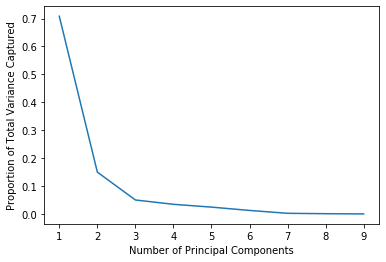

In [8]:
x = np.arange(1, 10)
var = [variance_captured(s, xi) for xi in x]
plt.plot(x, var);
plt.xlabel('Number of Principal Components');
plt.ylabel('Proportion of Total Variance Captured');

This tells us that PC1 captures ~70% of the variation in our data, PC2 captures ~15%, and so on.

In [9]:
for i in range(1, 8):
    print('{} of the total variance is captured by the first {} principal component(s)'.format(variance_captured_first_k(s, i), i))

0.7080735712664078 of the total variance is captured by the first 1 principal component(s)
0.8593064191401725 of the total variance is captured by the first 2 principal component(s)
0.9110163046930763 of the total variance is captured by the first 3 principal component(s)
0.9473118676982448 of the total variance is captured by the first 4 principal component(s)
0.9735469084798406 of the total variance is captured by the first 5 principal component(s)
0.9879336113358361 of the total variance is captured by the first 6 principal component(s)
0.9920357150026442 of the total variance is captured by the first 7 principal component(s)


The elbow method tells us that we should use either 2 or 3 principal components here, since there are diminishing returns for using any more. For ease of visualization, we will use 2.

## Interpreting the Principal Component Directions

As mentioned above, we have that $X = U \Sigma V^T$. We can right-multiply this equation by $V$, and since $V^TV = I$, we have that

$$\boxed{U\Sigma = XV}$$

$U \Sigma$ and $XV$ both compute our **principal components**, i.e., they both project our original data $X$ onto  our new-found directions. The first column of each of these matrices is our first principal component, and more generally, the $i$th column of these matrices is our $i$th principal component.

Let's zoom in on the calculation of $XV$.

First, we can think of $X$ as a set of $d$ **column vectors**, each of which corresponds to one of the columns in our dataset. The rows in $X$, then, each correspond to a single datapoint (in our case, a single player).

$$X = \begin{bmatrix}  | & | & ... & | \\ X_{:, 1} & X_{:, 2} & ... & X_{:, d} \\ | & | & ... & |  \end{bmatrix}$$

$V$, then, contains **the directions** of our new principal components. The $i$th column of $V$ contains the direction vector corresponding to the $i$th principal component. 

$$V = \begin{bmatrix} | & | & ... & | \\ v_{:, 1} & v_{:, 2} & ... & v_{:, d} \\ | & | & ... & |  \end{bmatrix}$$

Now, consider the product $XV$. By the nature of matrix multiplication, we can consider each of the columns in $V$ separately. Let's multiply by just the first column in $V$ first:

$$Xv_{:, 1} = X_{:, 1} v_{1, 1} + X_{:, 2} v_{2, 1} + ... + X_{:, d} v_{d, 1}$$

**The $j$th element of $v_{:, i}$ tells us the weight that principal component $i$ puts on column $j$.**

<br>

Looking at $V^T$, we have

$$V^T = \begin{bmatrix} - & v_1^T & - \\ - & v_2^T & - \\ & \vdots & \\ - & v_d^T & -  \end{bmatrix}$$

As a toy example, let's suppose our dataset has three columns – height, weight, and income (in that order). Suppose we compute the SVD of our data matrix, and get that the first row of $V^T$ is $v_1^T = \begin{bmatrix} -0.3 & 0.8 & 0.52 \end{bmatrix}$. This tells us that our first principal component is

$$PC1 = -0.3 \cdot \text{height} + 0.8 \cdot \text{weight} + 0.52 \cdot \text{income}$$

Great – now let's move back to our dataset. The `weights` dataframe that we create in the next cell will list each original column, along with the weights assigned to each column by the first two principal component directions. We extract the first two directions by taking the first two rows of `vt`.

In [10]:
weights = pd.DataFrame({
    'labels': df.iloc[:, 7:].columns,
    'PC1 weights': np.array(vt[0, :])[0],
    'PC2 weights': np.array(vt[1, :])[0],
}).set_index('labels')

In [11]:
weights.sort_values('PC1 weights')

,PC1 weights,PC2 weights
labels,,
PTS,-0.626930,-0.072263
FGA,-0.442062,-0.185876
MP,-0.333730,-0.197994
2PA,-0.325766,0.271668
FG,-0.215476,0.034322
FTA,-0.186783,0.101624
2P,-0.173027,0.211714
FT,-0.153964,0.036481
AST,-0.121689,-0.110856


To be explicit, our first PC is computed by the following transformation:

$$PC1 = -0.626930 \cdot \text{PTS} -0.442062 \cdot \text{FGA} + ... - 0.000199 \cdot \text{eFG%} $$

We can see that in PC1, only the first 10 or so columns have significant weight, and unsurprisingly, `PTS` (i.e. average points per game) is weighed the heaviest. This suggests that `PTS` contributes significantly to PC1. Columns such as `FT%`, `FG%`, `3P%`, `2P%`, and `eFG%` contribute very little, and as such, they are assigned very little weight in both PC1 and PC2. (Note, when talking about "weight", we only care about absolute weight.)

There are columns that are assigned sizeable weight in PC1 but not in PC2, such as `PTS` ($-0.626930$ vs $-0.072263$), and vice versa (such as `TRB`, which has weight $-0.116492$ in PC1 compared to $0.584020$ in PC2). This suggests that `PTS` is significantly more important in defining PC1 than it is in defining PC2, and that `TRB` is more important in defining `PC2`.

As we expect, our two principal component directions are orthogonal:

In [12]:
sum(weights.iloc[:, 1] * weights.iloc[:, 0])

2.0816681711721685e-17

This value is effectively 0; the difference is due to floating point computational error.

The key takeaway here is that the **rows of $V^T$**, or equivalently, the **columns of $V$**, contain the direction vectors that define our principal components.

## Visualizing our Data

Now that we've gotten our data down to two dimensions, we can visualize it. Below, let's plot our data projected onto our new axes: PC1 and PC2.

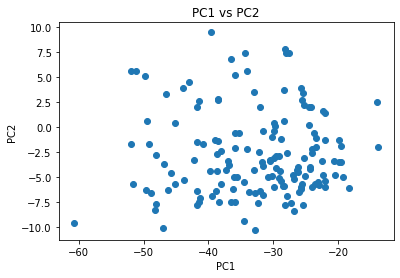

In [13]:
pc = d @ vt.T[:, :2]  # or, alternatively, u[:, :2] @ np.diag(s[:2])
plt.scatter(np.array(pc[:, 0]), np.array(pc[:, 1]))
plt.title('PC1 vs PC2');
plt.xlabel('PC1');
plt.ylabel('PC2');

Let's step back for a second. Our original data had 23 dimensions. Through PCA, we've generated a summary scatter plot of our data, in 2 dimensions, that captures ~86% of the variation in our original data. Pretty cool!

For fun, let's color each of our data points based on whether or not the corresponding player is a guard.

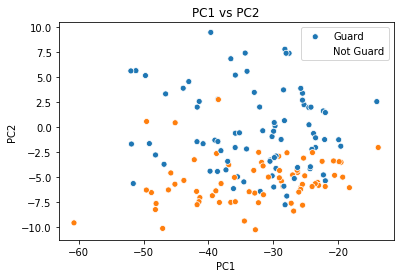

In [14]:
sns.scatterplot(x=list(pc[:, 0]), y=list(pc[:, 1]), hue=df['Pos'].apply(lambda x: 'G' in str(x)))
plt.legend(['Guard', 'Not Guard'])
plt.title('PC1 vs PC2');
plt.xlabel('PC1');
plt.ylabel('PC2');

This demonstrates the power of PCA – in addition to efficiently reducing the dimension of our data, our PCs implicitly *clustered*, or *separated*, our data for us. We see that the points that correspond to guards are generally above the points that correspond to non-guards.

This has nothing to do with dimensionality reduction, however, we will explore the idea of clustering and separation towards the end of the course.

Feel free to post on Piazza, or email us directly with questions.